# Koehn

In this notebook I replicate Koehn (2015): _What's in an embedding? Analyzing word embeddings through multilingual evaluation_. This paper proposes to i) evaluate an embedding method on more than one language, and ii) evaluate an embedding model by how well its embeddings capture syntactic features. He finds that most methods perform similarly on this task, but that dependency based embeddings perform better. Dependency based embeddings particularly perform better when you decrease the dimensionality. Overall, the aim is to have an evalation method that tells you something about the structure of the learnt representations.

Embedding models tested:
- cbow
- skip-gram
- glove
- dep
- cca
- brown

The proposed task is classification of various syntactic features, using an L2-regularized linear classifier. Koehn uses a majority baseline. Upper bound assigns the most probably class. He looked at the following features. Obviously, some features only apply to a subset of the lexicon.
- pos
- headpos (the pos of the word's head)
- label
- gender
- case
- number
- tense

He tested on the following languages:
- Basque
- English
- French
- German
- Hungarian
- Polish
- Swedish

Word embeddings were trained on automatically PoS-tagged and dependency-parsed data using existing models. This is so the dependency-based embeddings can be trained. The evaluation is on hand-labelled data. English training data is a subset of Wikipedia; English test data comes from PTB. For all other languages, both the training and test data come from a shared task on parsing morphologically rich languages. Koehn trained embeddings with window size 5 and 11 and dimensionality 10, 100, 200.

Dependency-based embeddings perform the best on almost all tasks. They even do well when the dimensionality is reduced to 10, while other methods perform poorly in this case.

I'll need:
- models
- learnt representations
- automatically labeled data
- hand-labeled data

In [14]:
%matplotlib inline
import os
import csv
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

data_path = '../../data'
tmp_path = '../../tmp'

## Models

## Learnt representations

### GloVe

In [5]:
size = 50
fname = 'embeddings/glove.6B.{}d.txt'.format(size)
glove_path = os.path.join(data_path, fname)
glove = pd.read_csv(glove_path, sep=' ', header=None, index_col=0, quoting=csv.QUOTE_NONE)
glove.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


## Features

In [59]:
fname = 'evaluation/dependency/UD_English/en-ud-features.csv'
features_path = os.path.join(data_path, fname)
features = pd.read_csv(features_path).set_index('form')
features.head()

/home/bacon/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,lemma,universal_pos,lg_pos,Case,Definite,Degree,Foreign,Gender,Mood,NumType,Number,Person,Poss,PronType,Reflex,Tense,VerbForm,Voice
form,,,,,,,,,,,,,,,,,,
Al,Al,PROPN,NNP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,-,PUNCT,HYPH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zaman,Zaman,PROPN,NNP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
:,:,PUNCT,:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American,american,ADJ,JJ,NaN,NaN,Pos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = pd.merge(glove, features, how='inner', left_index=True, right_index=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,Mood,NumType,Number,Person,Poss,PronType,Reflex,Tense,VerbForm,Voice
!,-0.58402,0.39031,0.65282,-0.3403,0.19493,-0.83489,0.11929,-0.57291,-0.56844,0.72989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!,-0.58402,0.39031,0.65282,-0.3403,0.19493,-0.83489,0.11929,-0.57291,-0.56844,0.72989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!,-0.58402,0.39031,0.65282,-0.3403,0.19493,-0.83489,0.11929,-0.57291,-0.56844,0.72989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!,-0.58402,0.39031,0.65282,-0.3403,0.19493,-0.83489,0.11929,-0.57291,-0.56844,0.72989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!,-0.58402,0.39031,0.65282,-0.3403,0.19493,-0.83489,0.11929,-0.57291,-0.56844,0.72989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prediction

In [75]:
def prepare_X_and_y(feature, data):
    """Return X and y ready for predicting feature from embeddings."""
    relevant_data = data[data[feature].notnull()]
    columns = list(range(1, size+1))
    X = relevant_data[columns].values
    y = relevant_data[feature].values
    le = LabelEncoder()
    le = le.fit(np.unique(y))
    y = le.transform(y)
    return X, y, le

def predict(model, X_test):
    """Wrapper for getting predictions."""
    results = model.predict_proba(X_test)
    return np.array([t for f,t in results]).reshape(-1,1)

def draw_roc(model, X_test, y_test):
    """Convenience function to draw ROC curve."""
    y_pred = predict(model, X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    label = r'$AUC={}$'.format(str(round(roc, 3)))
    plt.plot(fpr, tpr, label=label);
    plt.title('ROC')
    plt.xlabel('False positive rate');
    plt.ylabel('True positive rate');
    plt.legend();

def conmat(model, X_test, y_test, le):
    """Wrapper for sklearn's confusion matrix."""
    labels = le.classes_
    y_pred = model.predict(X_test)
    c = confusion_matrix(y_test, y_pred)
    sns.heatmap(c, annot=True, fmt='d', xticklabels=labels, 
                yticklabels=labels, cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')

def cross_val_auc(model, X, y):
    for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        model = model.fit(X_train, y_train)
        draw_roc(model, X_test, y_test)

def metrics(model, X, y, le):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    conmat(model, X_test, y_test, le)
    plt.figure()
    cross_val_auc(model, X, y)

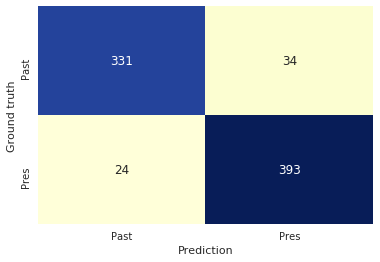

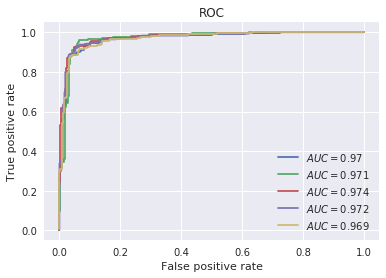

In [78]:
X, y, le = prepare_X_and_y('Tense', df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
model = model.fit(X_train, y_train)
metrics(model, X_test, y_test, le)